In [29]:
import pandas as pd
import numpy as np

from CudaSplines import GPUSpline,interpolation_point_inline

In [30]:
#load data to interplolate
input = pd.read_csv('input_data.csv')
x_data = input['time'].values[::20]
y_data = input['low'].values[::20]

In [31]:
# generate ponts to interpolate at
inter_x = np.sort(np.random.uniform(0,1300,(100000,100)),axis=1)

# Apply interpolation on GPU
spline = GPUSpline(x_data,y_data)
inter_y = spline.eval(inter_x)

# Inline function used from kernel

The interpolation can also be called from within an custom kernel using the interpolation_point_inline function passing the coefficients defined by the toTensor method

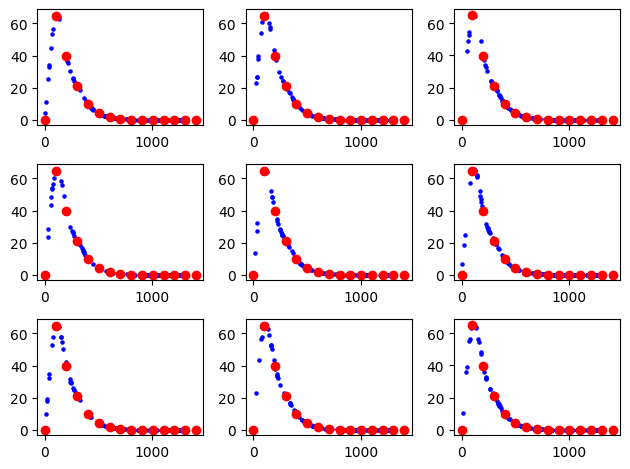

In [32]:
from numba import cuda
import matplotlib.pyplot as plt

coef = spline.toTensor()

@cuda.jit
def kernel(coef,x_array,y_array,int_pos):
    i = cuda.grid(1)
    if i < x_array.shape[0]:
        for k,dx in enumerate(x_array[i]):
            y_array[i,k] = interpolation_point_inline(coef,dx,int_pos[i])

tensor = spline.toTensor()
cuCoef = cuda.to_device(tensor)
cuInterX = cuda.to_device(inter_x)
inter_y = np.zeros_like(inter_x)
cuInterY = cuda.to_device(inter_y)
states = np.zeros(inter_x.shape[0],dtype=np.int64)
cuStates = cuda.to_device(states)

kernel[1000,100](cuCoef,cuInterX,cuInterY,cuStates)
cuda.synchronize()
inter_y = cuInterY.copy_to_host()

for i,(x,y) in enumerate(zip(inter_x[:9],inter_y[:9])):
    plt.subplot(3,3,i+1)
    plt.scatter(x,y,c='b',s=5)
    plt.scatter(x_data,y_data,c='r')
    
plt.tight_layout()
plt.show()

# Interpolated vectors

Several components of a vectorial function can be collected in an GPUSplineVector object.

In [1]:
import pandas as pd
import numpy as np

from CudaSplines import GPUSplineVector

In [2]:
input = pd.read_csv('input_data.csv')
x_data = input['time'].values[::20]
input_x = np.array([x_data,x_data])
y_data_low = input['low'].values[::20]
y_data_high = input['high'].values[::20]
input_y = np.array([y_data_low,y_data_high])

In [3]:
#generating sample points
n_sample = 1000
points_on_samp = np.random.randint(5,50,n_sample)
x_samp = np.nan*np.ones((n_sample,max(points_on_samp)))
for k,n in enumerate(points_on_samp):
    x_samp[k,:n] = np.sort(np.random.uniform(0,1300,n))

In [5]:
%%time
# Evaluate on GPU
vecSpline = GPUSplineVector(input_x,input_y,[0,1])
x_inter = vecSpline.eval(x_samp)

CPU times: total: 15.6 ms
Wall time: 12 ms
